In [1]:
import time
import numpy as np
import torch

import src.utils as ut
from src.SCMMappings_1_1 import Abstraction
from src.printing import AbstractionPrinter

import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork as BN
from pgmpy.factors.discrete import TabularCPD as cpd

In [2]:
seed = 0
np.random.seed(seed)  # Numpy module
torch.manual_seed(seed)

In [3]:
from src.examples import smokingmodels as ex

In [4]:
A_basic = Abstraction(*ex.basic_lung_cancer())
A_collapsing = Abstraction(*ex.collapsing_lung_cancer())
A_extended = Abstraction(*ex.extended_lung_cancer())
A_vstruct = Abstraction(*ex.vstruct_lung_cancer())


In [5]:
import src.evaluationsets as es
import src.learning as lng

In [6]:
J_basic = es.get_causal_sets_in_M1_with_directed_path_in_M1_and_M0(A_basic.M0, A_basic.M1, A_basic.a)

In [7]:
J_collapsing = [[['Smoking_'], ['Tar_']],
 [['Smoking_'], ['Cancer_']],
 [['Tar_'], ['Cancer_']]]

In [8]:
J_extended = [[['Smoking_'], ['Tar_']],
 [['Smoking_'], ['Cancer_']],
 [['Tar_'], ['Cancer_']]]

In [9]:
J_vstruct = [[['Smoking_'], ['Cancer_']],
 [['Smoking_'], ['Fatigue_']],
 [['Cancer_'], ['Fatigue_']]]

In [10]:
from src.nn import JointNeuralNet
from src.nn_losses import JSD_loss,RowMax_penalty

In [11]:
def calc_distance(Ws, alpha_index, alphas):
    distance = 0.0
    for key, value in alphas.items():
        distance += torch.sum(torch.abs(torch.from_numpy(value)-Ws[alpha_index[key]]))
    return distance

In [12]:
def train_a_JointNN_model(M0,M1,R,a,alphas,J,Ws,T,lmbda,num_epochs,lr):
    distances = np.zeros((num_epochs))
    jsds = np.zeros((num_epochs))
    end_results = {}
    
    
    model = JointNeuralNet(M0,M1,R,a,J,T)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion_jsd = JSD_loss()
    
    
    for epoch in range(num_epochs):
        lowpaths, highpaths, Ws = model()    
        loss_jsd = criterion_jsd(lowpaths, highpaths)
        loss = lmbda*loss_jsd
        
        distances[epoch] = calc_distance(Ws, model.alpha_index, alphas)
        jsds[epoch] = loss_jsd

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch+1) % 500 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}, JSD: {:.4f}'.format(epoch+1, num_epochs, loss, loss_jsd))
    
    learnt_alphas = {}
    for name in model.alphas_to_learn:
        learnt_alphas[name] = model.get_Wmatrix_by_name(name).detach()
        
    # discretize alphas and calc_distance
    discretized_alphas = {}
    for name, value in learnt_alphas.items():
        tmp = torch.zeros((value.shape))
        for i in range(value.shape[1]):
            tmp[torch.argmax(value[:,i]),i] = 1
        discretized_alphas[name] = tmp
    
    #calculate distance with discrete learnt alphas
    end_distance = 0.0
    for key, value in alphas.items():
        end_distance += torch.sum(torch.abs(torch.from_numpy(alphas[key])-discretized_alphas[key]))
    
    # jsd and penalty with initalised discrete alphas
    criterion_jsd = JSD_loss()
    end_model = JointNeuralNet(M0,M1,R,a,J,T,initialised_alphas=discretized_alphas)
    lowpaths, highpaths, Ws = end_model()    
    end_loss_jsd = criterion_jsd(lowpaths, highpaths)
    
    # store end results
    end_results['normalised_alphas'] = learnt_alphas
    end_results['discretized_alpha'] = discretized_alphas
    end_results['jsd'] = end_loss_jsd
    end_results['distance'] = end_distance
    
    return distances/len(alphas), jsds/len(J), end_results

In [13]:
lr = 0.01
num_epochs = 500
T = 0.1
lmbda=10.0
n_fold = 10
k_fold = 10

In [14]:
n_best_distance1 = np.zeros((n_fold,num_epochs))
n_best_jsd1 = np.zeros((n_fold,num_epochs))
n_best_end_results1 = []
n_time1 = np.zeros((n_fold))

n_best_distance2 = np.zeros((n_fold,num_epochs))
n_best_jsd2 = np.zeros((n_fold,num_epochs))
n_best_end_results2 = []
n_time2 = np.zeros((n_fold))

n_best_distance3 = np.zeros((n_fold,num_epochs))
n_best_jsd3 = np.zeros((n_fold,num_epochs))
n_best_end_results3 = []
n_time3 = np.zeros((n_fold))

n_best_distance4 = np.zeros((n_fold,num_epochs))
n_best_jsd4 = np.zeros((n_fold,num_epochs))
n_best_end_results4 = []
n_time4 = np.zeros((n_fold))


for n in range(n_fold):
    print(f"n fold {n+1}:")

    k_distances1 = np.zeros((k_fold,num_epochs))
    k_jsds1 = np.zeros((k_fold,num_epochs))
    k_end_results1 = []
    k_time1 = np.zeros((k_fold))
    
    k_distances2 = np.zeros((k_fold,num_epochs))
    k_jsds2 = np.zeros((k_fold,num_epochs))
    k_end_results2 = []
    k_time2 = np.zeros((k_fold))
    
    k_distances3 = np.zeros((k_fold,num_epochs))
    k_jsds3 = np.zeros((k_fold,num_epochs))
    k_end_results3 = []
    k_time3 = np.zeros((k_fold))
    
    k_distances4 = np.zeros((k_fold,num_epochs))
    k_jsds4 = np.zeros((k_fold,num_epochs))
    k_end_results4 = []
    k_time4 = np.zeros((k_fold))
    
    for fold in range(k_fold):
        st = time.time()
        distances_epoch1, jsds1, end_results1 = train_a_JointNN_model(A_basic.M0, A_basic.M1, A_basic.R, A_basic.a, A_basic.alphas, J_basic,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time1 = et - st
        
        st = time.time()
        distances_epoch2, jsds2, end_results2 = train_a_JointNN_model(A_collapsing.M0, A_collapsing.M1, A_collapsing.R, A_collapsing.a, A_collapsing.alphas, J_collapsing,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time2 = et - st
        
        st = time.time()
        distances_epoch3, jsds3, end_results3 = train_a_JointNN_model(A_extended.M0, A_extended.M1, A_extended.R, A_extended.a, A_extended.alphas, J_extended,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time3 = et - st
        
        st = time.time()
        distances_epoch4, jsds4, end_results4 = train_a_JointNN_model(A_vstruct.M0, A_vstruct.M1, A_vstruct.R, A_vstruct.a, A_vstruct.alphas, J_vstruct,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time4 = et - st
        
        
        k_distances1[fold] = distances_epoch1
        k_jsds1[fold] = jsds1
        k_end_results1.append(end_results1)
        k_time1[fold] = time1
        
        k_distances2[fold] = distances_epoch2
        k_jsds2[fold] = jsds2
        k_end_results2.append(end_results2)
        k_time2[fold] = time2
        
        k_distances3[fold] = distances_epoch3
        k_jsds3[fold] = jsds3
        k_end_results3.append(end_results3)
        k_time3[fold] = time3
        
        k_distances4[fold] = distances_epoch4
        k_jsds4[fold] = jsds4
        k_end_results4.append(end_results4)
        k_time4[fold] = time4
        
    k_losses1 = k_jsds1
    k_losses2 = k_jsds2
    k_losses3 = k_jsds3
    k_losses4 = k_jsds4
    best1 = np.argmin(k_losses1[:,-1])
    best2 = np.argmin(k_losses2[:,-1])
    best3 = np.argmin(k_losses3[:,-1])
    best4 = np.argmin(k_losses4[:,-1])
    
    n_best_distance1[n] = k_distances1[best1]
    n_best_jsd1[n] = k_jsds1[best1]
    n_best_end_results1.append(k_end_results1[best1])
    n_time1[n] = k_time1[best1]
    
    n_best_distance2[n] = k_distances2[best2]
    n_best_jsd2[n] = k_jsds2[best2]
    n_best_end_results2.append(k_end_results2[best2])
    n_time2[n] = k_time2[best2]
    
    n_best_distance3[n] = k_distances3[best3]
    n_best_jsd3[n] = k_jsds3[best3]
    n_best_end_results3.append(k_end_results3[best3])
    n_time3[n] = k_time3[best3]
    
    n_best_distance4[n] = k_distances4[best4]
    n_best_jsd4[n] = k_jsds4[best4]
    n_best_end_results4.append(k_end_results4[best4])
    n_time4[n] = k_time4[best4]
        
        

n fold 1:
Epoch [500/500], Loss: 0.0041, JSD: 0.0004
Epoch [500/500], Loss: 0.0796, JSD: 0.0080
Epoch [500/500], Loss: 0.2127, JSD: 0.0213
Epoch [500/500], Loss: 0.0423, JSD: 0.0042
Epoch [500/500], Loss: 0.0322, JSD: 0.0032
Epoch [500/500], Loss: 0.0312, JSD: 0.0031
Epoch [500/500], Loss: 0.0139, JSD: 0.0014
Epoch [500/500], Loss: 0.1117, JSD: 0.0112
Epoch [500/500], Loss: 0.0043, JSD: 0.0004
Epoch [500/500], Loss: 0.0777, JSD: 0.0078
Epoch [500/500], Loss: 0.0530, JSD: 0.0053
Epoch [500/500], Loss: 0.0508, JSD: 0.0051
Epoch [500/500], Loss: 0.0047, JSD: 0.0005
Epoch [500/500], Loss: 0.0804, JSD: 0.0080
Epoch [500/500], Loss: 0.0581, JSD: 0.0058
Epoch [500/500], Loss: 0.0931, JSD: 0.0093
Epoch [500/500], Loss: 0.0187, JSD: 0.0019
Epoch [500/500], Loss: 0.1490, JSD: 0.0149
Epoch [500/500], Loss: 0.0911, JSD: 0.0091
Epoch [500/500], Loss: 0.0453, JSD: 0.0045
Epoch [500/500], Loss: 0.0113, JSD: 0.0011
Epoch [500/500], Loss: 0.0846, JSD: 0.0085
Epoch [500/500], Loss: 0.0162, JSD: 0.0016
E

Epoch [500/500], Loss: 0.1829, JSD: 0.0183
Epoch [500/500], Loss: 0.0518, JSD: 0.0052
Epoch [500/500], Loss: 0.0172, JSD: 0.0017
Epoch [500/500], Loss: 0.0269, JSD: 0.0027
Epoch [500/500], Loss: 1.2205, JSD: 0.1220
Epoch [500/500], Loss: 0.0537, JSD: 0.0054
Epoch [500/500], Loss: 0.0046, JSD: 0.0005
Epoch [500/500], Loss: 2.9721, JSD: 0.2972
Epoch [500/500], Loss: 0.1087, JSD: 0.0109
Epoch [500/500], Loss: 0.0419, JSD: 0.0042
n fold 6:
Epoch [500/500], Loss: 0.0229, JSD: 0.0023
Epoch [500/500], Loss: 0.0198, JSD: 0.0020
Epoch [500/500], Loss: 0.0563, JSD: 0.0056
Epoch [500/500], Loss: 0.0749, JSD: 0.0075
Epoch [500/500], Loss: 0.0051, JSD: 0.0005
Epoch [500/500], Loss: 0.0229, JSD: 0.0023
Epoch [500/500], Loss: 1.0350, JSD: 0.1035
Epoch [500/500], Loss: 0.0430, JSD: 0.0043
Epoch [500/500], Loss: 0.0043, JSD: 0.0004
Epoch [500/500], Loss: 0.1331, JSD: 0.0133
Epoch [500/500], Loss: 0.0168, JSD: 0.0017
Epoch [500/500], Loss: 0.0613, JSD: 0.0061
Epoch [500/500], Loss: 0.0122, JSD: 0.0012
E

Epoch [500/500], Loss: 0.0038, JSD: 0.0004
Epoch [500/500], Loss: 0.1371, JSD: 0.0137
Epoch [500/500], Loss: 0.0908, JSD: 0.0091
Epoch [500/500], Loss: 0.0581, JSD: 0.0058
Epoch [500/500], Loss: 0.0299, JSD: 0.0030
Epoch [500/500], Loss: 0.0343, JSD: 0.0034
Epoch [500/500], Loss: 0.1539, JSD: 0.0154
Epoch [500/500], Loss: 0.0511, JSD: 0.0051
Epoch [500/500], Loss: 0.0043, JSD: 0.0004
Epoch [500/500], Loss: 0.0777, JSD: 0.0078
Epoch [500/500], Loss: 0.0696, JSD: 0.0070
Epoch [500/500], Loss: 0.0511, JSD: 0.0051
Epoch [500/500], Loss: 0.0159, JSD: 0.0016
Epoch [500/500], Loss: 0.0271, JSD: 0.0027
Epoch [500/500], Loss: 0.0952, JSD: 0.0095
Epoch [500/500], Loss: 0.0818, JSD: 0.0082
Epoch [500/500], Loss: 0.0038, JSD: 0.0004
Epoch [500/500], Loss: 0.0241, JSD: 0.0024
Epoch [500/500], Loss: 0.0710, JSD: 0.0071
Epoch [500/500], Loss: 0.0455, JSD: 0.0045


In [15]:
avg_dis1 = np.mean(n_best_distance1,axis=0)
avg_dis_err1 = np.std(n_best_distance1,axis=0)

avg_jsd1 = np.mean(n_best_jsd1,axis=0)
avg_jsd_err1 = np.std(n_best_jsd1,axis=0)

avg_time1 = np.mean(n_time1,axis=0)
avg_time_err1 = np.std(n_time1,axis=0)

print(f"Basic: Avg Alpha distance: {avg_dis1[-1]}")
print(f"Basic: Avg JSD: {avg_jsd1[-1]}")
print(f"Basic: Avg Time: {avg_time1}")
print(f"Basic: Avg Alpha distance SD: {avg_dis_err1[-1]}")
print(f"Basic: Avg JSD SD: {avg_jsd_err1[-1]}")
print(f"Basic: Avg Time SD: {avg_time_err1}")


avg_dis2 = np.mean(n_best_distance2,axis=0)
avg_dis_err2 = np.std(n_best_distance2,axis=0)

avg_jsd2 = np.mean(n_best_jsd2,axis=0)
avg_jsd_err2 = np.std(n_best_jsd2,axis=0)

avg_time2 = np.mean(n_time2,axis=0)
avg_time_err2 = np.std(n_time2,axis=0)

print(f"Collapsing: Avg Alpha distance: {avg_dis2[-1]}")
print(f"Collapsing: Avg JSD: {avg_jsd2[-1]}")
print(f"Collapsing: Avg Time: {avg_time2}")
print(f"Collapsing: Avg Alpha distance SD: {avg_dis_err2[-1]}")
print(f"Collapsing: Avg JSD SD: {avg_jsd_err2[-1]}")
print(f"Collapsing: Avg Time SD: {avg_time_err2}")


avg_dis3 = np.mean(n_best_distance3,axis=0)
avg_dis_err3 = np.std(n_best_distance3,axis=0)

avg_jsd3 = np.mean(n_best_jsd3,axis=0)
avg_jsd_err3 = np.std(n_best_jsd3,axis=0)

avg_time3 = np.mean(n_time3,axis=0)
avg_time_err3 = np.std(n_time3,axis=0)

print(f"Extended: Avg Alpha distance: {avg_dis3[-1]}")
print(f"Extended: Avg JSD: {avg_jsd3[-1]}")
print(f"Extended: Avg Time: {avg_time3}")
print(f"Extended: Avg Alpha distance SD: {avg_dis_err3[-1]}")
print(f"Extended: Avg JSD SD: {avg_jsd_err3[-1]}")
print(f"Extended: Avg Time SD: {avg_time_err3}")


avg_dis4 = np.mean(n_best_distance4,axis=0)
avg_dis_err4 = np.std(n_best_distance4,axis=0)

avg_jsd4 = np.mean(n_best_jsd4,axis=0)
avg_jsd_err4 = np.std(n_best_jsd4,axis=0)

avg_time4 = np.mean(n_time4,axis=0)
avg_time_err4 = np.std(n_time4,axis=0)

print(f"Vstruct: Avg Alpha distance: {avg_dis4[-1]}"
print(f"Vstruct: Avg JSD: {avg_jsd4[-1]}")
print(f"Vstruct: Avg Time: {avg_time4}")
print(f"Vstruct: Avg Alpha distance SD: {avg_dis_err4[-1]}")
print(f"Vstruct: Avg JSD SD: {avg_jsd_err4[-1]}")
print(f"Vstruct: Avg Time SD: {avg_time_err4}")

Basic: Avg Alpha distance: 0.03414670245901029
Basic: Avg JSD: 0.0004184913675999269
Basic: Avg Time: 0.3270437479019165
Basic: Avg Alpha distance SD: 0.06183215169888352
Basic: Avg JSD SD: 3.314511102020317e-05
Basic: Avg Time SD: 0.00742043898274068
Collapsing: Avg Alpha distance: 0.8820364925776332
Collapsing: Avg JSD: 0.0008063376221495371
Collapsing: Avg Time: 0.7787425279617309
Collapsing: Avg Alpha distance SD: 1.1700102995244326
Collapsing: Avg JSD SD: 0.00020226283490782726
Collapsing: Avg Time SD: 0.01355778465496714
Extended: Avg Alpha distance: 1.1407866112266976
Extended: Avg JSD: 0.001015695522073656
Extended: Avg Time: 0.7942958116531372
Extended: Avg Alpha distance SD: 1.6130193456389965
Extended: Avg JSD SD: 0.0008479195267208537
Extended: Avg Time SD: 0.0312559771860636
Vstruct: Avg Alpha distance: 1.8850931247075398
Vstruct: Avg JSD: 0.0013184250215999781
Vstruct: Avg Time: 0.8150799989700317
Vstruct: Avg Alpha distance SD: 0.703543170517486
Vstruct: Avg JSD SD: 0.00

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


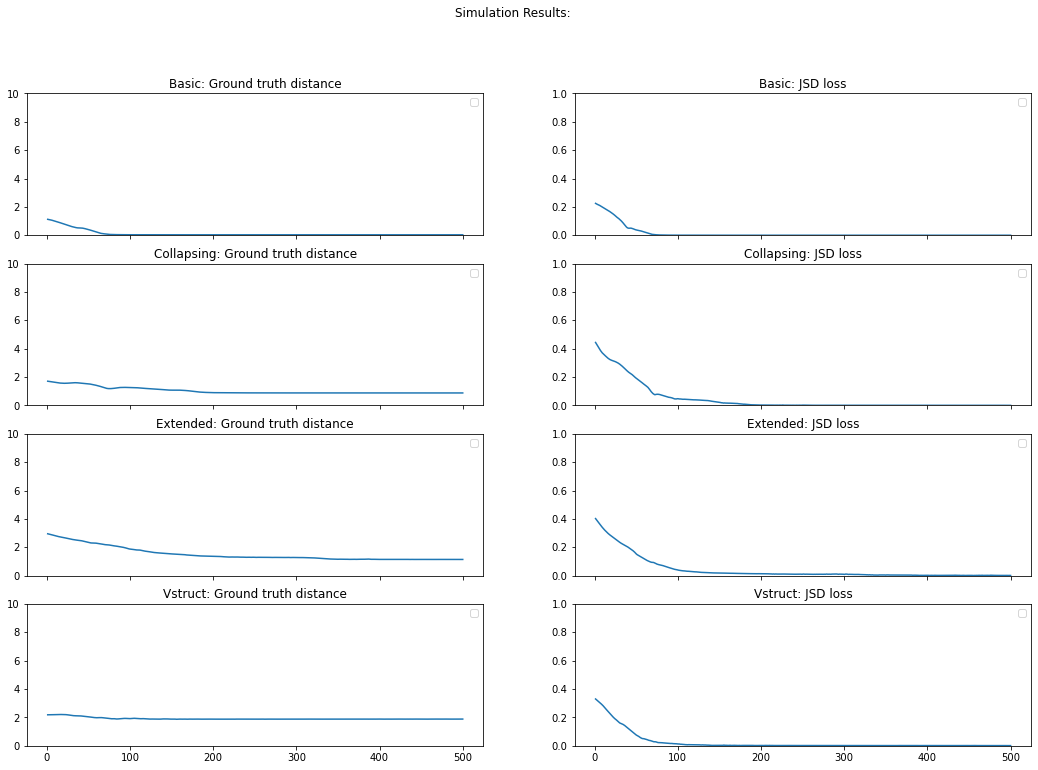

In [16]:

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(nrows=4, ncols=2, sharex=True,
                                    figsize=(18, 12))
time_epoch = np.array([i+1 for i in range(num_epochs)])
ax0.set_title('Basic: Ground truth distance')
ax0.plot(time_epoch, avg_dis1)
ax0.set_ylim([0,10])
ax0.legend()

ax1.set_title('Basic: JSD loss')
ax1.plot(time_epoch, avg_jsd1)
ax1.set_ylim([0,1])
ax1.legend()

ax2.set_title('Collapsing: Ground truth distance')
ax2.plot(time_epoch, avg_dis2)
ax2.set_ylim([0,10])
ax2.legend()

ax3.set_title('Collapsing: JSD loss')
ax3.plot(time_epoch, avg_jsd2)
ax3.set_ylim([0,1])
ax3.legend()

ax4.set_title('Extended: Ground truth distance')
ax4.plot(time_epoch, avg_dis3)
ax4.set_ylim([0,10])
ax4.legend()

ax5.set_title('Extended: JSD loss')
ax5.plot(time_epoch, avg_jsd3)
ax5.set_ylim([0,1])
ax5.legend()

ax6.set_title('Vstruct: Ground truth distance')
ax6.plot(time_epoch, avg_dis4)
ax6.set_ylim([0,10])
ax6.legend()

ax7.set_title('Vstruct: JSD loss')
ax7.plot(time_epoch, avg_jsd4)
ax7.set_ylim([0,1])
ax7.legend()

fig.suptitle('Simulation Results:')
plt.show()

In [17]:
# Save results
np.save('./results/synthetic/c/avg-best-distance-app3-nopenalty-basic', n_best_distance1)
np.save('./results/synthetic/c/avg-best-JSD-app3-nopenalty-basic', n_best_jsd1)
np.save('./results/synthetic/c/avg-best-time-app3-nopenalty-basic', n_time1)
np.save('./results/synthetic/c/avg-best-endresults-app3-nopenalty-basic', n_best_end_results1)

np.save('./results/synthetic/c/avg-best-distance-app3-nopenalty-collapsing', n_best_distance2)
np.save('./results/synthetic/c/avg-best-JSD-app3-nopenalty-collapsing', n_best_jsd2)
np.save('./results/synthetic/c/avg-best-time-app3-nopenalty-collapsing', n_time2)
np.save('./results/synthetic/c/avg-best-endresults-app3-nopenalty-collapsing', n_best_end_results2)

np.save('./results/synthetic/c/avg-best-distance-app3-nopenalty-extended', n_best_distance3)
np.save('./results/synthetic/c/avg-best-JSD-app3-nopenalty-extended', n_best_jsd3)
np.save('./results/synthetic/c/avg-best-time-app3-nopenalty-extended', n_time3)
np.save('./results/synthetic/c/avg-best-endresults-app3-nopenalty-extended', n_best_end_results3)

np.save('./results/synthetic/c/avg-best-distance-app3-nopenalty-vstruct', n_best_distance4)
np.save('./results/synthetic/c/avg-best-JSD-app3-nopenalty-vstruct', n_best_jsd4)
np.save('./results/synthetic/c/avg-best-time-app3-nopenalty-vstruct', n_time4)
np.save('./results/synthetic/c/avg-best-endresults-app3-nopenalty-vstruct', n_best_end_results4)